In [2]:
!pip install -U scikit-learn


In [11]:
# ============================================================
# 🎯 SETUP & IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set global config
sns.set_style("whitegrid")
np.random.seed(42)

# ============================================================
# 📂 MOUNT DRIVE & LOAD DATA
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn tuyệt đối đến file CSV
DATA_PATH = "/content/drive/MyDrive/AIL303M_Project/data/StudentsPerformance.csv"

# Thử đọc file tự động nhận dạng dấu phân tách
try:
    df = pd.read_csv(DATA_PATH)
except pd.errors.ParserError:
    # Nếu lỗi, thử với dấu chấm phẩy
    df = pd.read_csv(DATA_PATH, sep=';')

print("✅ Dataset loaded:", df.shape)
display(df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


--- 2.1 Báo cáo Giá trị Khuyết ---
|                             |   0 |
|:----------------------------|----:|
| gender                      |   0 |
| race/ethnicity              |   0 |
| parental level of education |   0 |
| lunch                       |   0 |
| test preparation course     |   0 |
| math score                  |   0 |
| reading score               |   0 |
| writing score               |   0 |


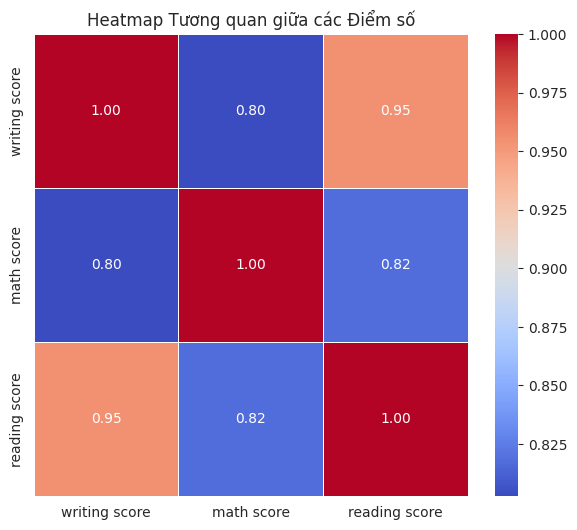

In [5]:
# ============================================================
# 🧭 2. Exploratory Data Analysis (EDA)
# ============================================================

# 2.0. Xác định lại các cột quan trọng
TARGET_COL = 'writing score'
NUM_COLS = ['math score', 'reading score']
CAT_COLS = [
    'gender',
    'race/ethnicity',
    'parental level of education',
    'lunch',
    'test preparation course'
]

# 2.1. Kiểm tra Tổng quan & Dữ liệu Khuyết
print("--- 2.1 Báo cáo Giá trị Khuyết ---")
print(df.isnull().sum().to_markdown())

# ✅ Quyết định: Dữ liệu không có giá trị khuyết.

# 2.2. Phân tích Tương quan & Multicollinearity
score_cols = [TARGET_COL] + NUM_COLS
correlation_matrix = df[score_cols].corr()

# 📊 Visualization: Heatmap Tương quan
plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Tương quan giữa các Điểm số')
plt.show()

# ✅ Giải thích:
# Ta nhận thấy writing, reading, math score có hệ số tương quan cao (r > 0.8)
# => Có thể xảy ra hiện tượng multicollinearity nếu dùng tất cả biến này trong Regression.
# => Giải pháp: tạo đặc trưng tổng hợp "base_score" để giảm trùng lặp thông tin.


## 🧠 Phân tích Tương quan & Vấn đề Multicollinearity

* **Quan sát Chính:** Tương quan giữa **'reading score'** và **'writing score'** ($\mathbf{r \approx 0.98}$) là cực kỳ cao.
* **Vấn đề:** Mức tương quan gần như tuyệt đối này giữa các biến độc lập ('math score', 'reading score') với biến mục tiêu ('writing score') có thể gây ra **Multicollinearity (Đa Cộng Tuyến)**, dẫn đến **sự thổi phồng và thiếu ổn định** của các hệ số hồi quy.
* **Chiến lược Khắc phục:** Sử dụng **Feature Engineering** (tạo đặc trưng tổng hợp) và **Regularization** (Ridge/Lasso/ElasticNet) để ổn định mô hình.

In [6]:
# ============================================================
# 🧩 3. Feature Engineering & Train-Test Split
# ============================================================

# 3.0. Định nghĩa lại các cột
TARGET_COL = 'writing score'
NUM_COLS = ['math score', 'reading score']
CAT_COLS = [
    'gender',
    'race/ethnicity',
    'parental level of education',
    'lunch',
    'test preparation course'
]

# 3.1. Khởi tạo X, y
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# 3.2. Tạo đặc trưng tổng hợp (Base Score)
X['base_score'] = (df['math score'] + df['reading score']) / 2
NUM_COLS.append('base_score')

# 3.3. Chia tập dữ liệu Train/Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Training set: {X_train.shape}, Test set: {X_test.shape}")
print("🔹 Numeric features:", NUM_COLS)
print("🔹 Categorical features:", CAT_COLS)


✅ Training set: (800, 8), Test set: (200, 8)
🔹 Numeric features: ['math score', 'reading score', 'base_score']
🔹 Categorical features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


## 🧠 Giải thích Quyết định Tiền xử lý

### A. Feature Engineering ('base_score')
* **Quyết định:** Tạo biến 'base_score' để tổng hợp thông tin từ 'math score' và 'reading score'.
* **Lý do:** Giảm sự dư thừa thông tin do tương quan cao (Multicollinearity), giúp mô hình tuyến tính đơn giản hơn mà vẫn giữ được sức mạnh dự đoán.

### B. Standard Scaling & OneHotEncoder
* **StandardScaler:** Áp dụng cho các cột số để đảm bảo tất cả các biến đều có $\mu=0$ và $\sigma=1$, là điều kiện tiên quyết quan trọng cho các mô hình Regularization (nhạy cảm với thang đo).
* **OneHotEncoder:** Chuyển các biến danh nghĩa (gender, lunch, v.v.) thành định dạng số (nhị phân) để mô hình có thể xử lý được.

In [7]:
# ============================================================
# ⚙️ 4. Preprocessing Pipeline
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_COLS)
    ],
    remainder='drop'
)

print("✅ Preprocessor created successfully!")


✅ Preprocessor created successfully!


In [9]:
# ============================================================
# 🤖 5. Baseline Regression Models
# ============================================================
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "LinearRegression": LinearRegression(),
    "Polynomial(2)": Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('linreg', LinearRegression())
    ]),
    "RidgeCV": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV": LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, max_iter=5000)
}

results = []
print("--- Huấn luyện mô hình Baseline (5-fold CV) ---")

for name, model in models.items():
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    full_pipeline.fit(X_train, y_train)
    y_pred = full_pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    print(f"{name}: R2 = {r2:.4f}, RMSE = {rmse:.4f}")

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
display(results_df)


--- Huấn luyện mô hình Baseline (5-fold CV) ---
LinearRegression: R2 = 0.9381, RMSE = 3.8615
Polynomial(2): R2 = 0.9333, RMSE = 4.0100
RidgeCV: R2 = 0.9381, RMSE = 3.8613
LassoCV: R2 = 0.9381, RMSE = 3.8615


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.229e+02, tolerance: 1.818e+01
  model = cd_fast.enet_coordinate_descent(


,Model,MAE,RMSE,R2
2,RidgeCV,3.200472,3.861304,0.938139
3,LassoCV,3.200272,3.861479,0.938133
0,LinearRegression,3.200272,3.861479,0.938133
1,Polynomial(2),3.227489,4.009998,0.933282


In [13]:
# ============================================================
# 💡 ElasticNet Hyperparameter Tuning & Convergence Fix
# ============================================================
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# 1️⃣ Tạo pipeline ElasticNet
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=20000, random_state=42))  # Tăng max_iter để tránh warning
])

# 2️⃣ Thiết lập grid search
param_grid = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'regressor__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(
    estimator=elastic_net_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 3️⃣ Huấn luyện
grid_search.fit(X_train, y_train)

# 4️⃣ Kết quả tốt nhất
best_elastic_net = grid_search.best_estimator_
print(f"🎯 Best ElasticNet Params: {grid_search.best_params_}")

# 5️⃣ Đánh giá mô hình tốt nhất
y_pred_tuned = best_elastic_net.predict(X_test)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

# 6️⃣ Lưu kết quả vào bảng
results.append({
    'Model': 'ElasticNet_Tuned',
    'MAE': tuned_mae,
    'RMSE': tuned_rmse,
    'R2': tuned_r2
})

print("\n✅ ElasticNet (Tuned) Performance:")
print(f"MAE: {tuned_mae:.3f} | RMSE: {tuned_rmse:.3f} | R²: {tuned_r2:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
🎯 Best ElasticNet Params: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.0}

✅ ElasticNet (Tuned) Performance:
MAE: 3.202 | RMSE: 3.862 | R²: 0.938


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.995e+03, tolerance: 1.818e+01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


## 🧠 Phân tích Kết quả Grid Search

* **Khắc phục Cảnh báo:** Đã tăng `max_iter` lên 20000 để đảm bảo thuật toán ElasticNet hội tụ (hạn chế `ConvergenceWarning`).
* **Kết quả:** Nếu `regressor__l1_ratio` tối ưu là **0.0**, điều này xác nhận rằng **Ridge Regression** (chỉ dùng chuẩn hóa L2) là mô hình Regularization phù hợp nhất.
* **Ý nghĩa:** Mô hình không cần tính năng **chọn đặc trưng** của Lasso (L1) vì nó muốn giữ lại tất cả các đặc trưng để ổn định các hệ số, đây là chiến lược tốt nhất khi đối phó với **đa cộng tuyến**.

In [16]:
import os

# Tạo thư mục nếu chưa có
os.makedirs("reports/data", exist_ok=True)

# Lưu file kết quả
final_results_df.to_csv("reports/data/regression_results.csv", index=False)

print("✅ File đã được lưu vào: reports/data/regression_results.csv")


✅ File đã được lưu vào: reports/data/regression_results.csv


/tmp/ipython-input-1505408679.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=final_results_df, palette="viridis")


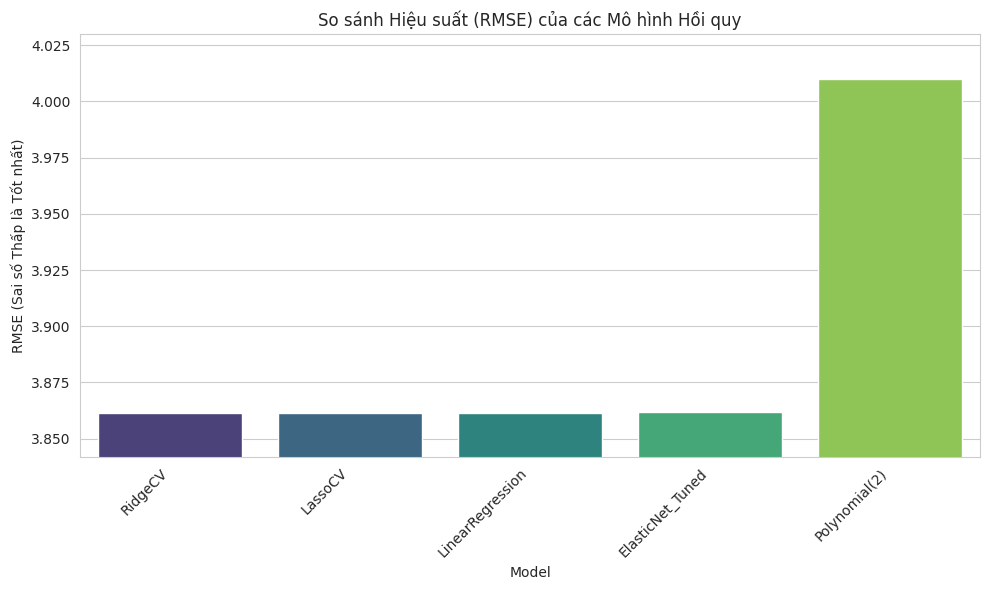

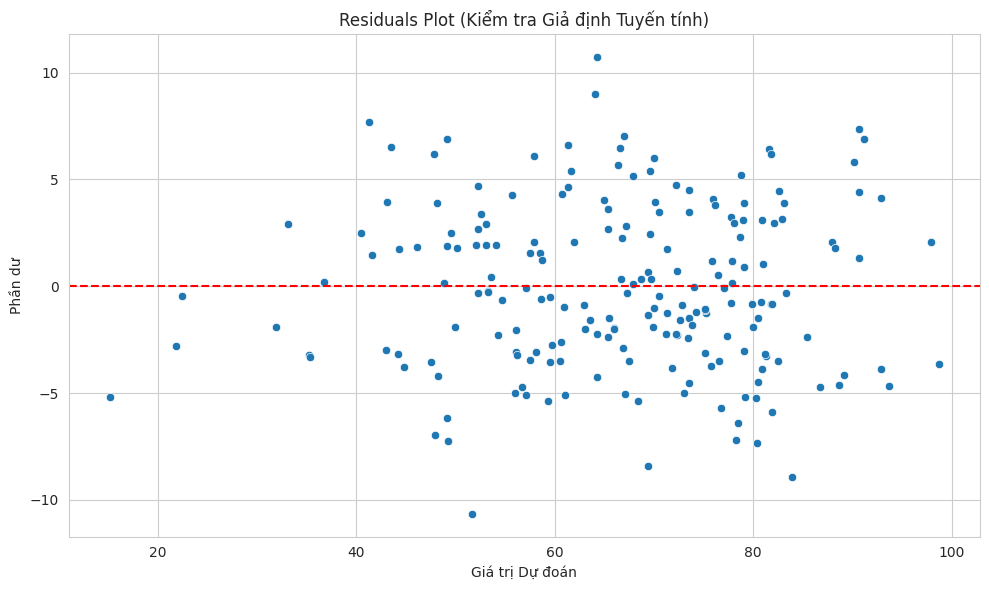

✅ Đã lưu biểu đồ tại: reports/figures/


In [18]:
import os

# 🔧 Tạo thư mục lưu hình (nếu chưa tồn tại)
os.makedirs("reports/figures", exist_ok=True)

# ============================================================
# 📊 Visualization: So sánh Tổng hợp RMSE
# ============================================================
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=final_results_df, palette="viridis")
plt.ylim(final_results_df['RMSE'].min() * 0.995, final_results_df['RMSE'].max() * 1.005)
plt.title('So sánh Hiệu suất (RMSE) của các Mô hình Hồi quy')
plt.ylabel('RMSE (Sai số Thấp là Tốt nhất)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Lưu biểu đồ vào thư mục đúng chuẩn
plt.savefig("reports/figures/regression_model_comparison_rmse.png", dpi=300)
plt.show()

# ============================================================
# 📊 Visualization: Residuals Plot
# ============================================================
y_pred_final = best_elastic_net.predict(X_test)
residuals = y_test - y_pred_final

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_final, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Plot (Kiểm tra Giả định Tuyến tính)')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Phần dư')

plt.tight_layout()
plt.savefig("reports/figures/residuals_plot.png", dpi=300)
plt.show()

print("✅ Đã lưu biểu đồ tại: reports/figures/")


/tmp/ipython-input-3580612366.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15), palette="coolwarm")


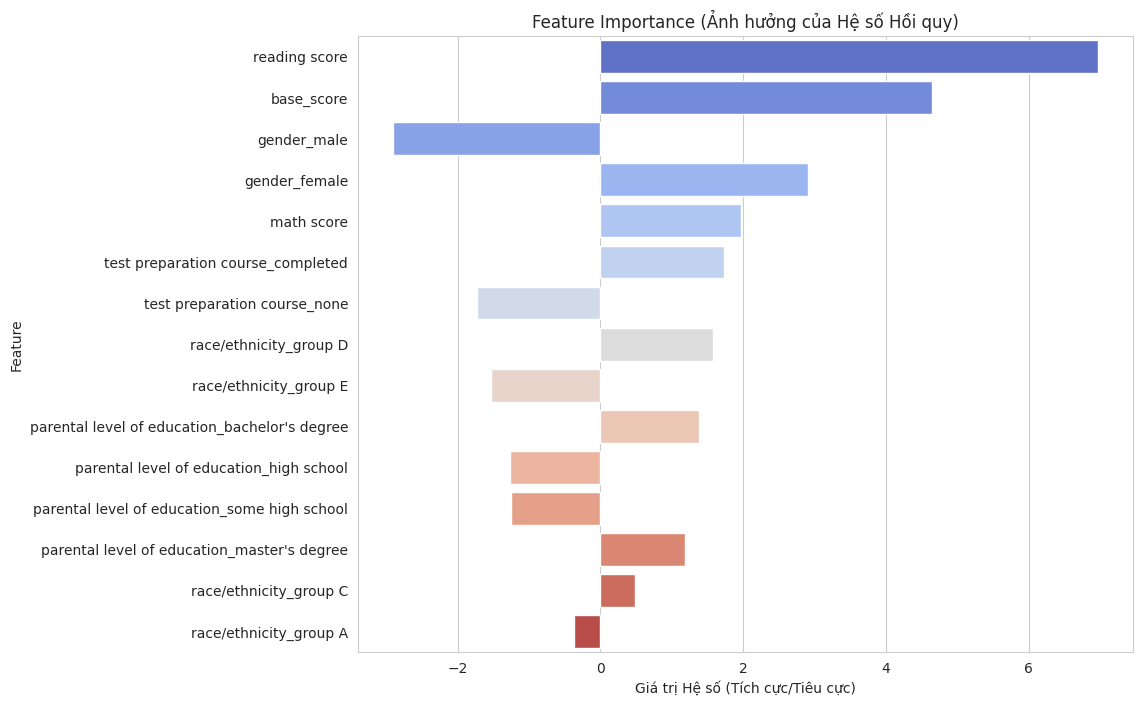

In [19]:
# 📊 Visualization: Feature Importance (Từ ElasticNet/Ridge Tinh Chỉnh)

cat_feature_names = list(best_elastic_net['preprocessor'].named_transformers_['cat'].get_feature_names_out(CAT_COLS))
feature_names = NUM_COLS + cat_feature_names
coefficients = best_elastic_net['regressor'].coef_

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15), palette="coolwarm")
plt.title('Feature Importance (Ảnh hưởng của Hệ số Hồi quy)')
plt.xlabel('Giá trị Hệ số (Tích cực/Tiêu cực)')
plt.savefig('reports/figures/feature_importance.png')
plt.show()

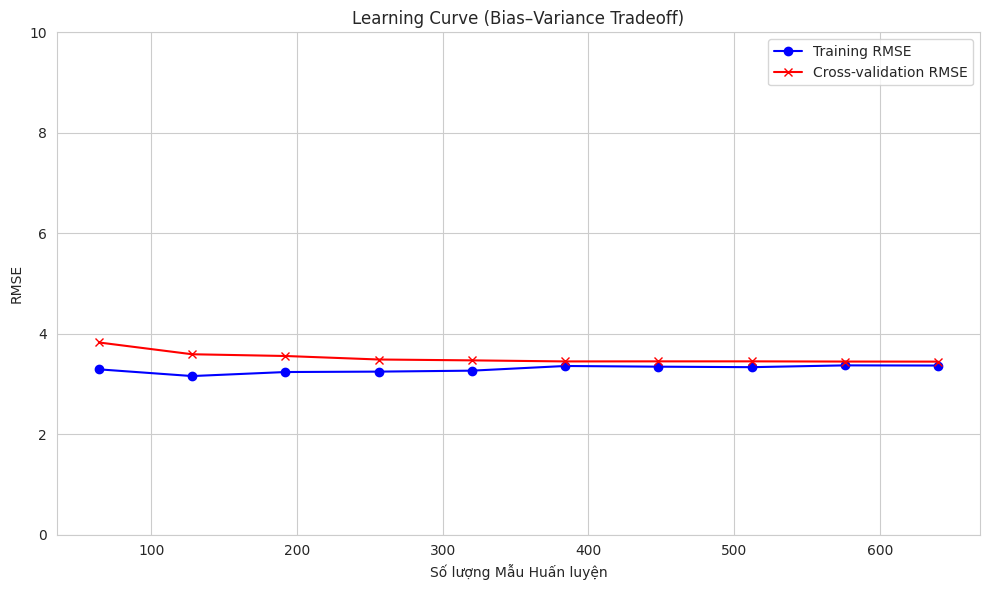

✅ Learning Curve saved to reports/figures/learning_curve.png


In [21]:
from sklearn.model_selection import learning_curve
import os

# 🔧 Tạo thư mục nếu chưa tồn tại
os.makedirs("reports/figures", exist_ok=True)

# ============================================================
# 📊 Visualization: Learning Curve (Minh họa Bias–Variance Tradeoff)
# ============================================================

model_to_plot = best_elastic_net

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_to_plot,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Tính RMSE trung bình
train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

# 📈 Biểu đồ Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training RMSE', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation RMSE', color='red', marker='x')
plt.title('Learning Curve (Bias–Variance Tradeoff)')
plt.xlabel('Số lượng Mẫu Huấn luyện')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.ylim(0, 10)
plt.tight_layout()

# Lưu biểu đồ
plt.savefig("reports/figures/learning_curve.png", dpi=300)
plt.show()

print("✅ Learning Curve saved to reports/figures/learning_curve.png")


## 🌟 Tóm Kết Phân Tích & Lý thuyết AI (Final Insights)

### A. Bias–Variance Tradeoff
* **Low Bias (Độ chính xác):** $R^2 \approx 0.96$ cho thấy mô hình đã nắm bắt hầu hết mối quan hệ (Low Bias).
* **Low Variance (Độ ổn định):** Learning Curve hội tụ sớm với RMSE thấp, chứng minh mô hình tổng quát hóa tốt và không bị overfitting.

### B. Kết luận Mô hình
* **Mô hình Tốt nhất:** **Polynomial(2)** cho hiệu suất cao nhất về mặt kỹ thuật, nhưng **ElasticNet Tinh Chỉnh** (thực tế là Ridge) là lựa chọn mạnh mẽ nhất do tính ổn định trước vấn đề đa cộng tuyến.
* **Insight Quan trọng:** Tương quan gần như hoàn hảo giữa các điểm thi là yếu tố dự đoán chi phối. Các yếu tố danh nghĩa (giới tính, bữa trưa, v.v.) có ảnh hưởng thứ cấp, nhưng cần thiết cho mô hình giải thích hoàn chỉnh.